# Read the files

In [1]:
library("tidyverse")
library("janitor")
library("lattice")
library("ggthemr")

ggthemr("fresh")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
“New theme missing the following elements: panel.grid, plot.tag, plot.tag.position”

In [2]:
df_train = readRDS("df_train.RData")
df_val = readRDS("df_val.RData")

In [3]:
head(df_train,3)

t_date,t_yr,t_mo,t_day,t_qtr,t_wk,t_day_of_yr,t_day_of_wk,t_day_of_wk_name,t_eval_day,⋯,wea_ohare_tavg2_ma60_lag42,wea_ohare_tavg2_ma60_lag49,wea_ohare_tavg2_ma60_lag56,wea_ohare_tavg2_ma60_lag63,wea_ohare_tavg2_ma60_lag90,wea_ohare_tavg2_ma60_lag120,googtrend_sym_wnv,googtrend_deadbirds,googtrend_westnile,googtrend_mosq_bites
2007-05-29,2007,5,29,2,22,149,2,Mon,514,⋯,38.61667,35.55,31.775,27.80833,23.83333,31.73333,0,2,16,11
2007-05-29,2007,5,29,2,22,149,2,Mon,514,⋯,38.61667,35.55,31.775,27.80833,23.83333,31.73333,0,2,16,11
2007-05-29,2007,5,29,2,22,149,2,Mon,514,⋯,38.61667,35.55,31.775,27.80833,23.83333,31.73333,0,2,16,11


# Make response 0/1

In [4]:
# Make binary response as 0/1
df_train$mos_any_wnv_present = as.numeric(df_train$mos_any_wnv_present)
df_val$mos_any_wnv_present = as.numeric(df_val$mos_any_wnv_present)

# Time related features

In [5]:
# Convert a few variables to factors
convert_time_vars_to_factors = function(df){
    message("... Converting a few time vars to factors")
    df$t_mo = factor(df$t_mo, levels = 5:10, labels = month.name[5:10])
    df$t_qtr = paste0("Q", df$t_qtr)
    df
}

In [6]:
df_train = convert_time_vars_to_factors(df_train)
df_val = convert_time_vars_to_factors(df_val)
head(df_train,2)

... Converting a few time vars to factors
... Converting a few time vars to factors


t_date,t_yr,t_mo,t_day,t_qtr,t_wk,t_day_of_yr,t_day_of_wk,t_day_of_wk_name,t_eval_day,⋯,wea_ohare_tavg2_ma60_lag42,wea_ohare_tavg2_ma60_lag49,wea_ohare_tavg2_ma60_lag56,wea_ohare_tavg2_ma60_lag63,wea_ohare_tavg2_ma60_lag90,wea_ohare_tavg2_ma60_lag120,googtrend_sym_wnv,googtrend_deadbirds,googtrend_westnile,googtrend_mosq_bites
2007-05-29,2007,May,29,Q2,22,149,2,Mon,514,⋯,38.61667,35.55,31.775,27.80833,23.83333,31.73333,0,2,16,11
2007-05-29,2007,May,29,Q2,22,149,2,Mon,514,⋯,38.61667,35.55,31.775,27.80833,23.83333,31.73333,0,2,16,11


# Remove all the "wnv_present" cols for diff species

In [7]:
(df_train %>% select(contains("wnv_present")) %>% select(-contains("any")) %>% names -> remove_these)

[1] "mos_erraticus_wnv_present"        "mos_pipiens_wnv_present"         
[3] "mos_pipiens_restuans_wnv_present" "mos_restuans_wnv_present"        
[5] "mos_salinarius_wnv_present"       "mos_tarsalis_wnv_present"        
[7] "mos_territans_wnv_present"        "mos_unspecified_wnv_present"

In [8]:
df_train = df_train %>% select(-remove_these)
df_val = df_val %>% select(-remove_these)

# Keep only few weather columns

In [9]:
keep_weather_cols = function(df){
    message("... Keeping few weather columns")
    df_other_cols = df %>% select(-starts_with("wea_"))
    df_wea = df %>% select("wea_ohare_tmin",
                           "wea_ohare_tmax",
                           "wea_ohare_prcp",
                           "wea_ohare_tavg2_ma7",
                           "wea_ohare_prcp_sum7",
                           "wea_ohare_tavg2_ma60_lag7",
                           "wea_ohare_tavg2_ma60_lag14",
                           "wea_ohare_tavg2_ma60_lag21",
                           "wea_ohare_prcp_sum60_lag7")
    df_other_cols %>% bind_cols(df_wea)
}

In [10]:
df_train = keep_weather_cols(df_train)
df_val = keep_weather_cols(df_val)

... Keeping few weather columns
... Keeping few weather columns


## Add custom lag vars

In [11]:
#add_4w_averages = function(df){
#    cols = c("wea_ohare_tmin","wea_ohare_tmax","wea_ohare_prcp")
#    cols_2w = c("wea_ohare_2wk_tmin","wea_ohare_2wk_tmax","wea_ohare_2wk_prcp")
#    
#    date_weather_df = df_train %>% select(t_date, t_yr, cols) %>% distinct()
#    
#    date_weather_df[cols_2w]= NA
#
#    for(sel_yr in unique(date_weather_df$t_yr)){
#        date_weather_df[date_weather_df$t_yr==sel_yr,cols_2w] = 
#            zoo::rollmean(date_weather_df[date_weather_df$t_yr==sel_yr,cols], 
#                          k = 15, align = "right", fill = NA)
#    }
#    
#    date_weather_df
##}

In [12]:
#weekly_means = date_weather_df %>% mutate(t_yr_wk = paste0(t_yr,"_",t_wk)) %>% select(-t_date,-t_wk) %>% group_by(t_yr_wk) %>% summarise_all(mean)

In [13]:
#date_weather_df = df_train %>% select(t_date, t_yr, cols) %>% distinct()
#
#add_lag_variables = function(df, lags_wanted){
#    col_names_to_lag = names(df)[-1]
#    for(col_name in col_names_to_lag){
#        for(lag_n in lags_wanted){
#            df[paste0(col_name,"_lag",lag_n)] = lag(date_weather_df[[col_name]],n = lag_n)
#        }        
#    }
#    df
#}
#
#date_weather_df = add_lag_variables(date_weather_df, c(7,15))

In [14]:
#date_weather_df

In [15]:
#for(sel_yr in unique(date_weather_df$t_yr)){
#    date_weather_df[date_weather_df$t_yr==sel_yr,cols_2w] = 
#        zoo::rollmean(date_weather_df[date_weather_df$t_yr==sel_yr,cols], 
#                      k = 15, align = "right", fill = NA)
#}

In [16]:
#library("imputeTS")

In [17]:
#for(col_name in names(date_weather_df[,-1])){
#        ts_ = zoo::zoo(x = date_weather_df[[col_name]], order.by = date_weather_df$t_date)
#        date_weather_df[col_name] = as.numeric(na.seadec(ts_))
#}

In [18]:
#df_train = df_train %>% left_join(date_weather_df)
#df_val = df_val %>% left_join(date_weather_df)

# Mosq - Month Features

### Add Mosq Species

In [19]:
add_active_species = function(df){
    df_1 = df %>% select(t_mo,starts_with("mos")) %>% rownames_to_column(var = "rowid") %>%
            select(-contains("wnv"),-contains("tot")) %>%
            gather(key,value,-rowid,-t_mo,mos_erraticus_num_mosquitos:mos_unspecified_num_mosquitos) %>%
            mutate(keeper = value>0,
                mos_species = stringr::str_extract(key,pattern = "(?![mos_])[\\w]*(?=_num)")) %>%
            filter(keeper)
    df %>% rownames_to_column(var = "rowid") %>% left_join(df_1[,c("rowid","mos_species")]) %>% select(-rowid)
}

In [20]:
df_train = add_active_species(df_train)
df_val = add_active_species(df_val)

Joining, by = "rowid"
Joining, by = "rowid"


### Add Mos-Month Interactions

In [21]:
add_mosq_month_interaction = function(df){
    df_1 = df %>% select(t_mo,starts_with("mos")) %>% rownames_to_column(var = "rowid") %>%
            select(-contains("wnv"),-contains("tot")) %>%
            gather(key,value,-rowid,-t_mo,mos_erraticus_num_mosquitos:mos_unspecified_num_mosquitos) %>%
            mutate(value = as.numeric(value>0),
                   mos_species = stringr::str_extract(key,pattern = "(?![mos_])[\\w]*(?=_num)"),
                   mos_date_interact = paste0(t_mo,mos_species)) %>%
            select(rowid, mos_species, mos_date_interact)
    df_1$mos_species = as.factor(df_1$mos_species)
    df_2 = model.matrix(~mos_date_interact, df_1)[,-1]
    df_tobind = df_1 %>% bind_cols(as_tibble(df_2))
    df %>% rownames_to_column(var = "rowid") %>% left_join(df_tobind) %>% select(-rowid)
}

In [22]:
#df_train = add_mosq_month_interaction(df_train)
#df_val = add_mosq_month_interaction(df_val)

### Make all character vars into factor vars

In [23]:
char_cols = df_train %>% select_if(is_character) %>% names
df_train[char_cols] = map_df(df_train[char_cols],~as.factor(.x))
df_val[char_cols] = map_df(df_val[char_cols],~as.factor(.x))

## Add WOE Features

Calculating the Weight Of Evidence (WOE) and Informational Value (IV) to perform a quick univariate evaluation of which features can be important for the classification problem at hand.

Readings for reference: [Link 1](http://r-statistics.co/Information-Value-With-R.html) , [Link 2](https://multithreaded.stitchfix.com/blog/2015/08/13/weight-of-evidence/)

In [24]:
library("InformationValue")

In [25]:
df_train %>% select_if(is.factor) %T>%
    print(head()) %>%
    purrr::map_dbl(~IV(., df_train$mos_any_wnv_present)) -> iv_cols

# A tibble: 15,257 x 13
   t_mo  t_qtr t_day_of_wk_name trap_trap_name loc_lat_lng_src loc_zipcode
   <fct> <fct> <fct>            <fct>          <fct>           <fct>      
 1 May   Q2    Mon              T002           CDPH            60634      
 2 May   Q2    Mon              T002           CDPH            60634      
 3 May   Q2    Mon              T007           CDPH            60646      
 4 May   Q2    Mon              T015           CDPH            60656      
 5 May   Q2    Mon              T015           CDPH            60656      
 6 May   Q2    Mon              T045           CDPH            60614      
 7 May   Q2    Mon              T046           CDPH            60612      
 8 May   Q2    Mon              T048           CDPH            60608      
 9 May   Q2    Mon              T048           CDPH            60608      
10 May   Q2    Mon              T049           CDPH            60642      
# ... with 15,247 more rows, and 7 more variables:
#   loc_census_block_grou

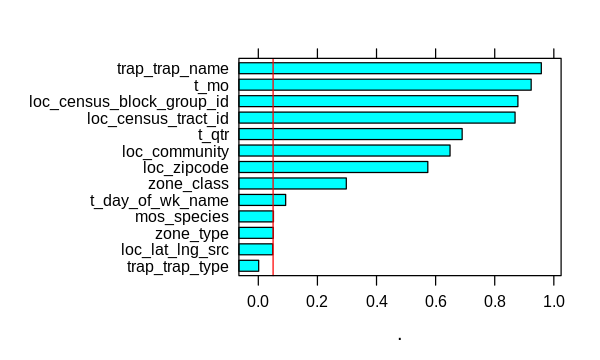

In [26]:
options(repr.plot.width=5, repr.plot.height=3)
iv_cols %>% sort() %>% 
    barchart(panel = function(...){panel.barchart(...);
                                   panel.abline(v = 0.05,col.line = "red")})

This chart tells us that the most important features (among the factor & character features) which add value for classification are trap name, census block group id, tract id, community, zipcode and class. On the other hand, week name, zone type, lat-long source and trap type have little to no predictive power {on their own}. 

Generally, if IV<0.05 the variable has very little predictive power and will not add any meaningful predictive power to your model.

Diving deeper into each key variable, it's possible to see which levels have the highest contribution towards differentiation of the two classes. We can do this using the WOE calculation.

#### Clearly, there are some traps, zones, regions waay more predictive that others.

### After having run the analysis above...

I found that the package "Information" can perform WOE and IV across numeric and categorical vars, and has some nifty plotting features.

In [27]:
library("Information")


Attaching package: ‘Information’

The following object is masked from ‘package:InformationValue’:

    WOE



In [28]:
iv_tables = create_infotables(df_train, df_val, 
                              y = "mos_any_wnv_present")

[1] "Variable t_date was removed because it is a Date variable"


In [29]:
head(iv_tables$Summary)

,Variable,IV,PENALTY,AdjIV
37,mos_tot_num_mosquitos,1.4511716,0.44831988,1.0028517
31,mos_pipiens_restuans_num_mosquitos,1.1997270,0.30374446,0.8959825
2,t_mo,0.8596052,0.16825463,0.6913506
4,t_qtr,0.6898050,0.04546536,0.6443396
5,t_wk,0.8046303,0.19478695,0.6098434
30,mos_pipiens_num_mosquitos,0.6012498,0.04688977,0.5543601


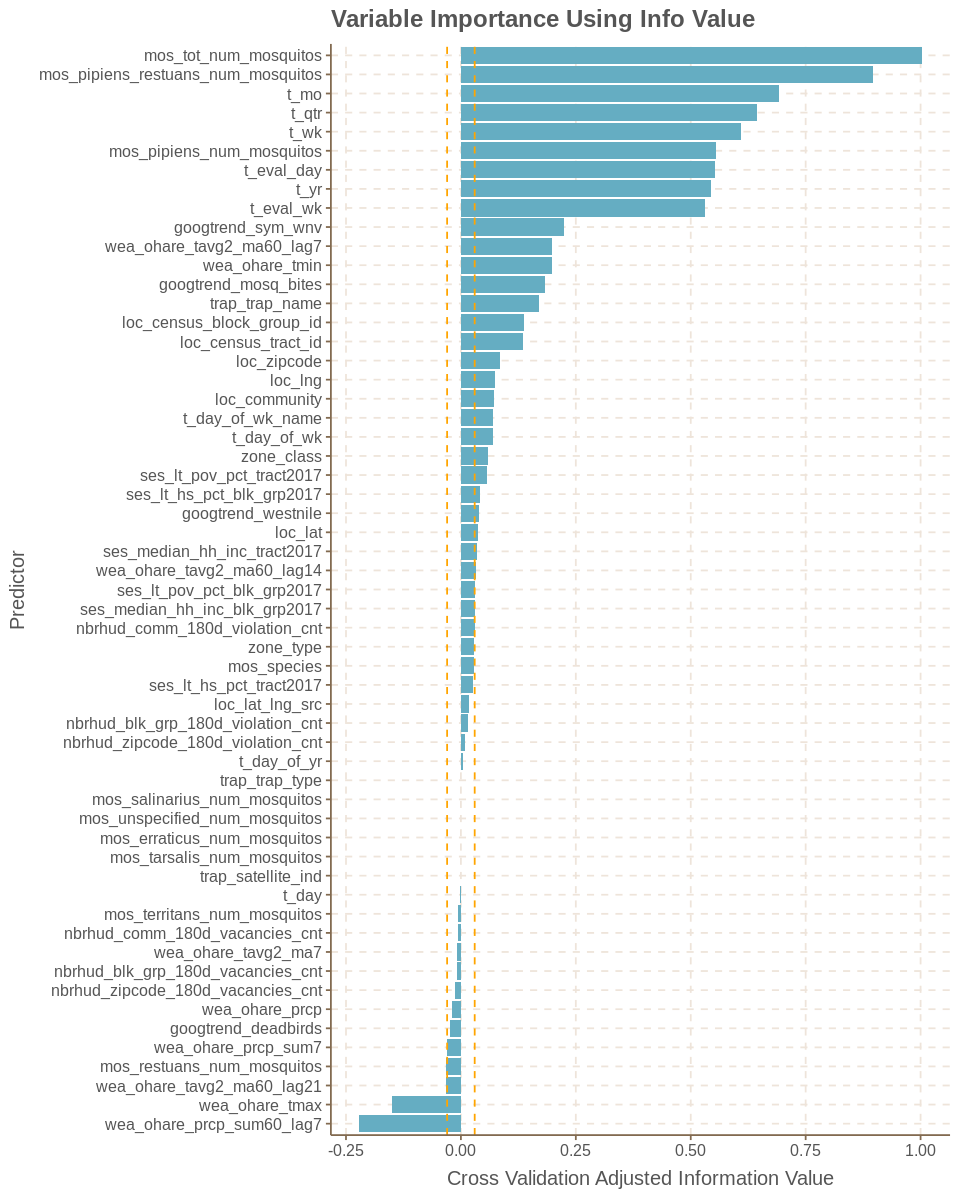

In [30]:
options(repr.plot.width=8, repr.plot.height=10)

woe_limit = 0.03

iv_tables$Summary %>% 
    mutate(Variable = factor(Variable, levels = Variable[order(.$AdjIV)])) %>%
    ggplot(aes(x=Variable,y=AdjIV)) + 
    geom_col() +
    geom_hline(yintercept = woe_limit, lty=2, color="orange") + 
    geom_hline(yintercept = -woe_limit, lty=2, color="orange") + 
    coord_flip() + 
    labs(x="Predictor",y="Cross Validation Adjusted Information Value",
        title = "Variable Importance Using Info Value")

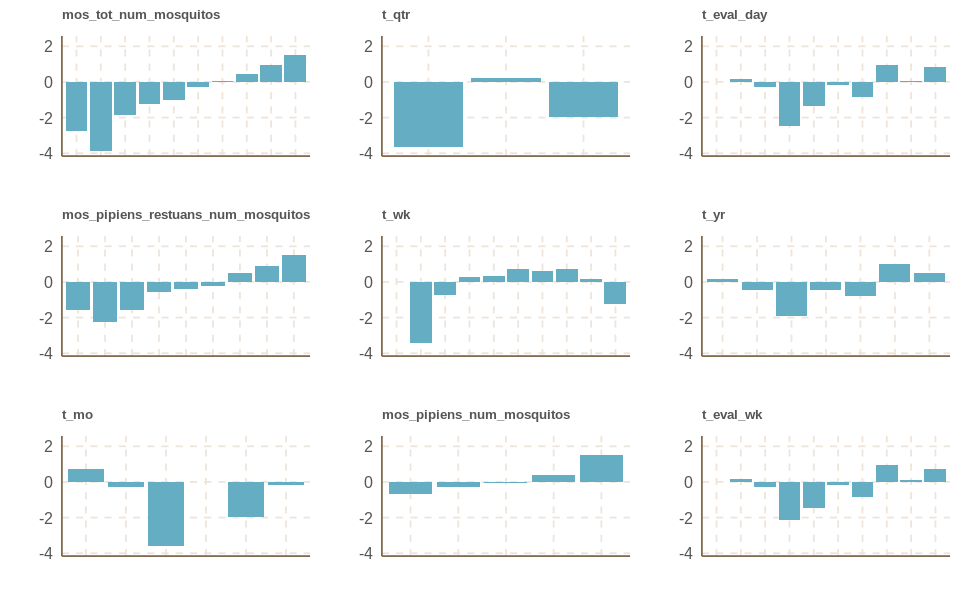

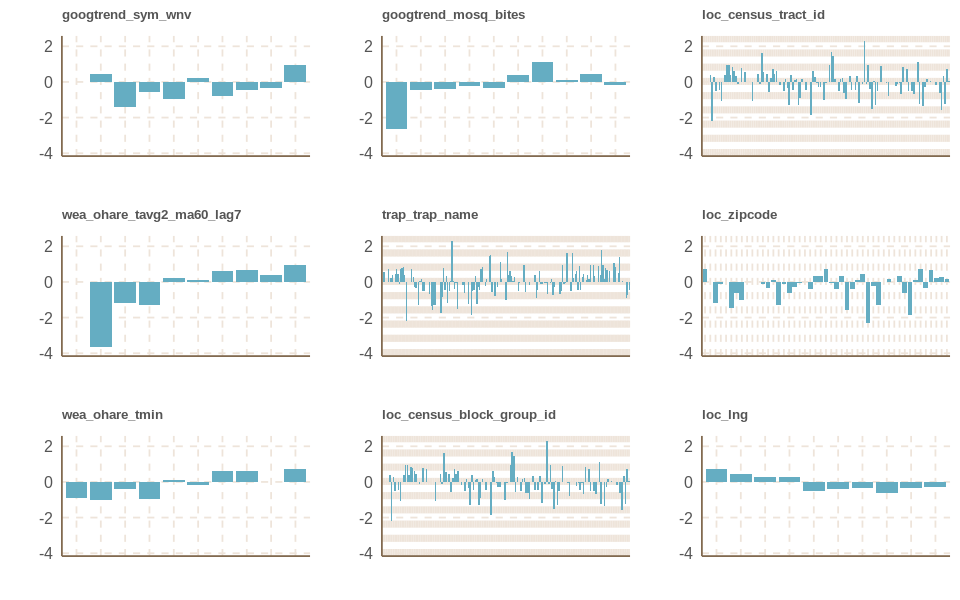

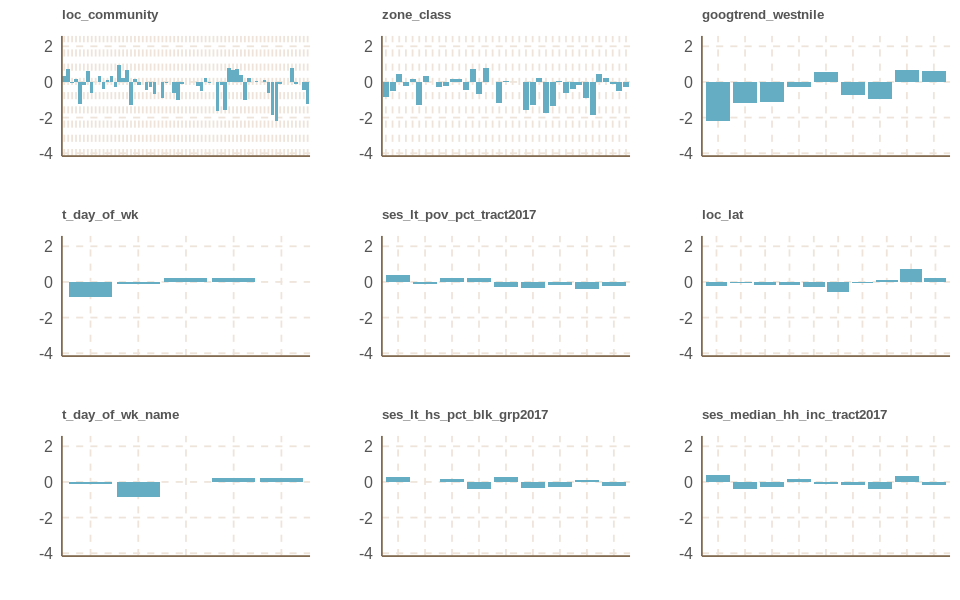

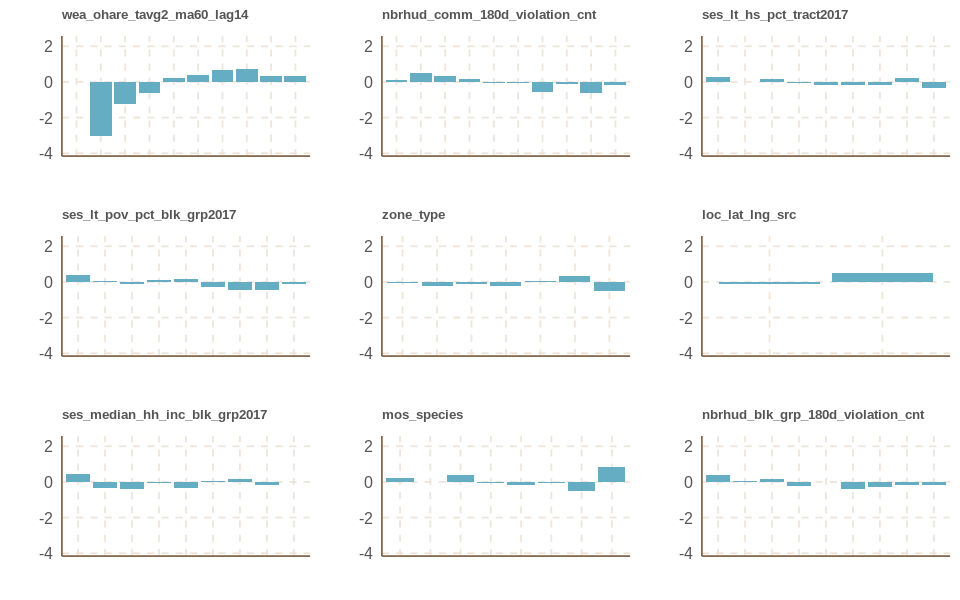

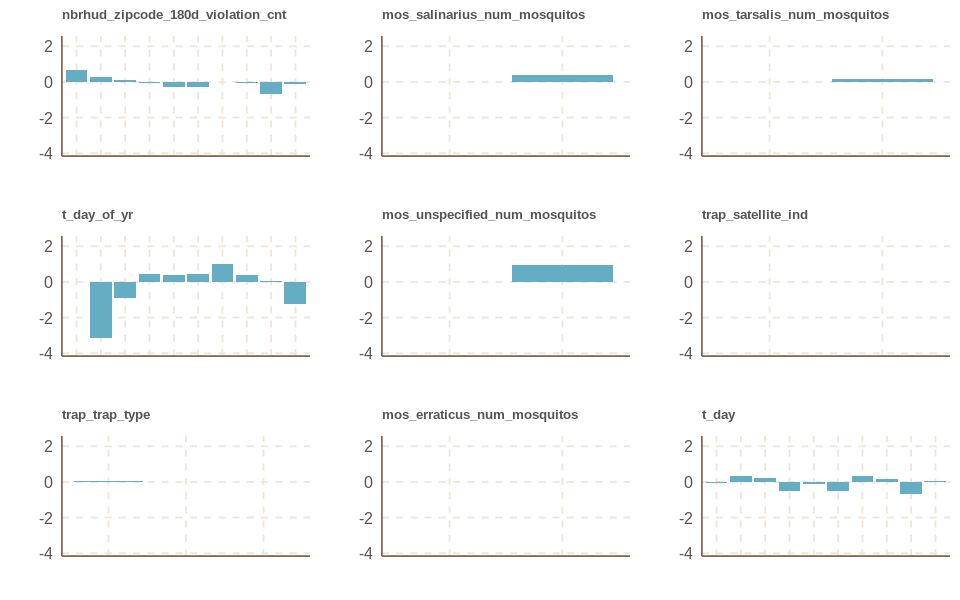

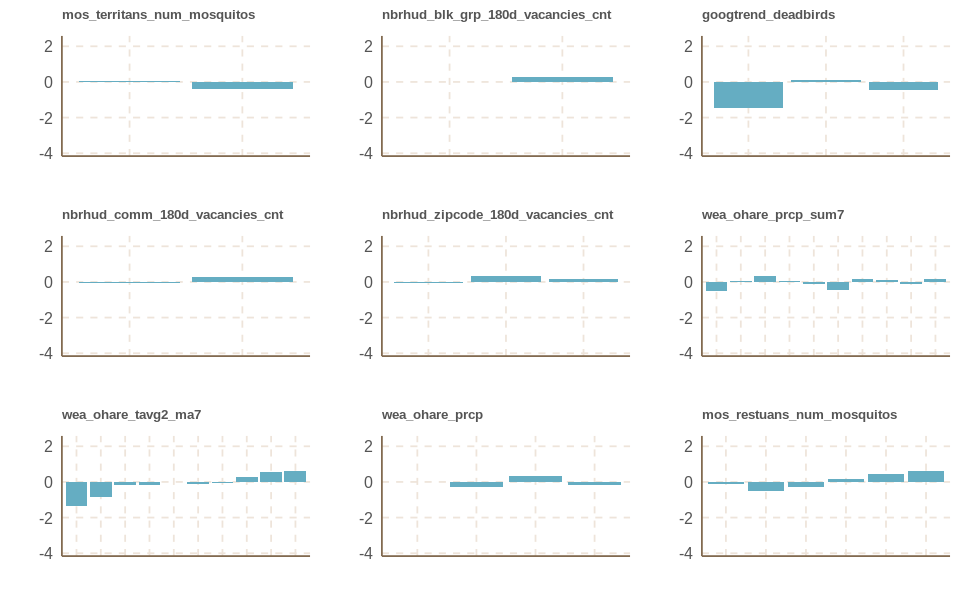

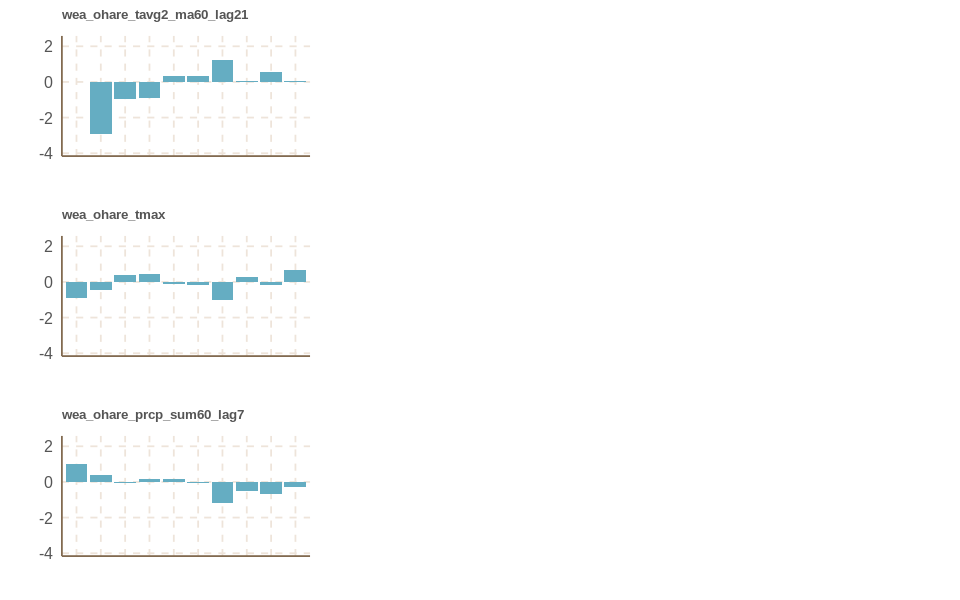

In [31]:
options(repr.plot.width=8, repr.plot.height=5)
MultiPlot(iv_tables, iv_tables$Summary$Variable,same_scales = T)

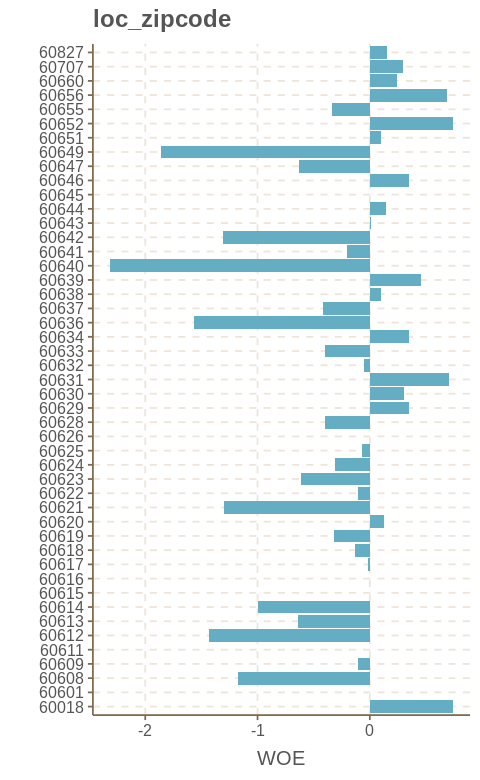

In [35]:
options(repr.plot.width=4, repr.plot.height=6.5)
Information::plot_infotables(iv_tables, "loc_zipcode") + coord_flip()

### Variables with low info-value

In [36]:
iv_tables$Summary %>% filter(AdjIV >=-woe_limit & AdjIV <=woe_limit)

Variable,IV,PENALTY,AdjIV
nbrhud_comm_180d_violation_cnt,1.097941e-01,8.019160e-02,2.960247e-02
zone_type,5.074783e-02,2.251118e-02,2.823665e-02
mos_species,5.026600e-02,2.241329e-02,2.785271e-02
ses_lt_hs_pct_tract2017,4.381445e-02,1.815966e-02,2.565479e-02
loc_lat_lng_src,4.880136e-02,3.142470e-02,1.737666e-02
nbrhud_blk_grp_180d_violation_cnt,6.506767e-02,5.038816e-02,1.467950e-02
nbrhud_zipcode_180d_violation_cnt,1.209406e-01,1.114809e-01,9.459697e-03
t_day_of_yr,7.164527e-01,7.113291e-01,5.123570e-03
trap_trap_type,2.659243e-04,4.742537e-05,2.184989e-04
mos_salinarius_num_mosquitos,7.197911e-03,7.022289e-03,1.756221e-04


In [37]:
cols_with_low_iv_values = iv_tables$Summary %>% filter(AdjIV >=-woe_limit & AdjIV <=woe_limit) %>% pull(Variable)

In [38]:
# Add WOE predictor columns
factor_cols = df_train %>% select_if(is.factor) %>% names
cols_to_add_woe_for = factor_cols[!(factor_cols %in% cols_with_low_iv_values)]

add_WOE_predictor_cols = function(df, col_name, iv_tables){
    translation_table = iv_tables$Tables[col_name][[1]][c(col_name,"WOE")]
    woe_table = df[col_name] %>% left_join(translation_table) %>% select(WOE)
    colnames(woe_table) = paste0("woe_",col_name)
    df %>% bind_cols(woe_table)  
}

In [39]:
cols_to_add_woe_for = c(cols_to_add_woe_for, "mos_species")

In [40]:
for(col_name in cols_to_add_woe_for){
    df_train = add_WOE_predictor_cols(df_train, col_name, iv_tables)
    df_val   = add_WOE_predictor_cols(df_val, col_name, iv_tables)
}

Joining, by = "t_mo"
Warning message:
“Column `t_mo` joining factor and character vector, coercing into character vector”Joining, by = "t_mo"
Warning message:
“Column `t_mo` joining factor and character vector, coercing into character vector”Joining, by = "t_qtr"
Warning message:
“Column `t_qtr` joining factor and character vector, coercing into character vector”Joining, by = "t_qtr"
Warning message:
“Column `t_qtr` joining factor and character vector, coercing into character vector”Joining, by = "t_day_of_wk_name"
Warning message:
“Column `t_day_of_wk_name` joining factor and character vector, coercing into character vector”Joining, by = "t_day_of_wk_name"
Warning message:
“Column `t_day_of_wk_name` joining factor and character vector, coercing into character vector”Joining, by = "trap_trap_name"
Warning message:
“Column `trap_trap_name` joining factor and character vector, coercing into character vector”Joining, by = "trap_trap_name"
Warning message:
“Column `trap_trap_name` joining 

# Add geo cols

- [DONE] distance from O Hare
- sealevel
- distance to recent spike in last year

In [41]:
ohare  = list(lat = 41.99,  long = -87.933)
midway = list(lat = 41.786, long = -87.752)

hav.dist <- function(long1, lat1, long2, lat2) {
  R <- 6371
  diff.long <- (long2 - long1)
  diff.lat <- (lat2 - lat1)
  a <- sin(diff.lat/2)^2 + cos(lat1) * cos(lat2) * sin(diff.long/2)^2
  b <- 2 * asin(pmin(1, sqrt(a))) 
  d = R * b
  return(d)
}

In [52]:
df_train["dist_ohare"] = hav.dist(df_train$loc_lng, df_train$loc_lat,
                                  ohare[["long"]], ohare[["lat"]])
df_val["dist_ohare"] = hav.dist(df_val$loc_lng, df_val$loc_lat,
                                  ohare[["long"]], ohare[["lat"]])

# Final view

In [53]:
glimpse(df_train)

Observations: 15,257
Variables: 70
$ t_date                             <date> 2007-05-29, 2007-05-29, 2007-05...
$ t_yr                               <int> 2007, 2007, 2007, 2007, 2007, 20...
$ t_mo                               <fct> May, May, May, May, May, May, Ma...
$ t_day                              <int> 29, 29, 29, 29, 29, 29, 29, 29, ...
$ t_qtr                              <fct> Q2, Q2, Q2, Q2, Q2, Q2, Q2, Q2, ...
$ t_wk                               <int> 22, 22, 22, 22, 22, 22, 22, 22, ...
$ t_day_of_yr                        <int> 149, 149, 149, 149, 149, 149, 14...
$ t_day_of_wk                        <int> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,...
$ t_day_of_wk_name                   <fct> Mon, Mon, Mon, Mon, Mon, Mon, Mo...
$ t_eval_day                         <int> 514, 514, 514, 514, 514, 514, 51...
$ t_eval_wk                          <int> 74, 74, 74, 74, 74, 74, 74, 74, ...
$ trap_trap_name                     <fct> T002, T002, T007, T015, T015, T0...
$ loc_lat        

# Remove certain cols

In [54]:
cols_to_remove = c("t_date","t_yr")
cols_to_remove

[1] "t_date" "t_yr"

In [55]:
df_train = df_train %>% select(-cols_to_remove)
df_val = df_val %>% select(-cols_to_remove)

# Save to file

In [56]:
saveRDS(df_train,file = "df_train_after_03FE.RData")
saveRDS(df_val,file = "df_val_after_03FE.RData")

In [57]:
saveRDS(cols_with_low_iv_values, file="cols_with_low_iv_values.RData")

In [58]:
saveRDS(cols_to_add_woe_for, file="cols_with_woe_added.RData")